<center>
<h1>Doing statistical game theory: (Towards) the missing manual</h1>
<i>Theodore L. Turocy</i><br/>
<i>University of East Anglia</i>
<br/><br/>
<h3>EC'16 workshop
24 July 2016</h3>
</center>

<img src="https://www.uea.ac.uk/cbess-theme/images/custom/img-cbess-logo.png"/>
<img src="http://beta.nottingham.ac.uk/esrc-nibs/images-multimedia/logos/NIBS-logo.png"/>

This is part of a larger project on the practical application of quantal response equilibrium and related concepts of statistical game theory.

It is inspired in part by several recent papers by Camerer, Palfrey, and coauthors, developing various generalizations of quantal response equilibrium (including heterogeneous QRE) and links between QRE and cognitive hierarchy/level-k models.

These are exciting developments (in the view of this researcher) because this appears to offer a coherent and flexible statistical framework to use as a foundation for behavioural modeling in games, and a data-driven approach to behavioural game theory.

What we will do in this talk is to use the facilities in Gambit to explore how to fit QRE to small games.  We'll focus on small games so that all computations can be done live in this Jupyter notebook - making this talk equally a useful practical tutorial, and automatically documenting all the computations done in support of the development of the lines of thought herein.

**Advertisement**: Thanks to some friends of Gambit at Cardiff (and support from a Google Summer of Code internship), Gambit is being integrated into the SAGE package for computational mathematics in Python (http://www.sagemath.org).  Also as part of this, it will soon be possible to interact with Gambit (alongside all of the mathetmatical tools that SAGE bundles) using notebooks like this one, on a server via your web browser.

We begin by looking at some of the examples from the original Quantal Response Equilibrium paper:

McKelvey, R. D. and Palfrey, T. R. (1995) Quantal response equilibrium for normal form games. *Games and Economic Behavior* **10**: 6-38.

We will take the examples slightly out of order, and look first at the non-constant sum game of "asymmetric" matching pennies they consider from

Ochs, J. (1995) Games with unique mixed strategy equilibria: An experimental study. *Games and Economic Behavior* **10**: 174-189.

In [1]:
import math
import numpy
import scipy.optimize
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import gambit

In [2]:
gambit.__version__

'16.0.0'

Set up the payoff matrices. McKPal95 multiply the basic payoff matrix by a factor to translate to 1982 US cents. In addition, the exchange rates for the two players were different in the original experiment, accounting for the different multiplicative factors.

In [3]:
m1 = numpy.array([[ 4, 0 ], [ 0, 1 ]], dtype=gambit.Decimal) * gambit.Decimal("0.2785")
m2 = numpy.array([[ 0, 1 ], [ 1, 0 ]], dtype=gambit.Decimal) * gambit.Decimal("1.1141")   
m1, m2

(array([[Decimal('1.1140'), Decimal('0.0000')],
        [Decimal('0.0000'), Decimal('0.2785')]], dtype=object),
 array([[Decimal('0.0000'), Decimal('1.1141')],
        [Decimal('1.1141'), Decimal('0.0000')]], dtype=object))

Create a Gambit game object from these payoff matrices (`from_arrays` is new in Gambit 15.1.0)

In [4]:
g = gambit.Game.from_arrays(m1, m2)
g

NFG 1 R "" { "1" "2" }

{ { "1" "2" }
{ "1" "2" }
}
""

{
{ "" 1.1140, 0.0000 }
{ "" 0.0000, 1.1141 }
{ "" 0.0000, 1.1141 }
{ "" 0.2785, 0.0000 }
}
1 2 3 4 

First, we can verify there is a unique mixed strategy equilibrium.  Player 1 should randomize equally between his strategies; player 2 should play his second strategy with probability 4/5.  It is the "own-payoff" effect to Player 1 which made QRE of interest in this game.

In [5]:
gambit.nash.enummixed_solve(g)

[[[Fraction(1, 2), Fraction(1, 2)], [Fraction(1, 5), Fraction(4, 5)]]]

Now, we set out to replicate the QRE estimation using the fixed-point method from the original paper.
We set up a mixed strategy profile, which we populate with frequencies of each strategy.
Data are reported in blocks of 16 plays, with $n=128$ pairs of players.

In [6]:
data1 = g.mixed_strategy_profile()
data1[g.players[0]] = [ 16*128*0.527, 16*128*(1.0-0.527) ]
data1[g.players[1]] = [ 16*128*0.366, 16*128*(1.0-0.366) ]
data1

[[1079.296, 968.704], [749.568, 1298.432]]

With the data in hand, we ask Gambit to find the QRE which best fits the data, using maximum likelihood.

In [7]:
qre1 = gambit.nash.logit_estimate(data1)
qre1

LogitQREMixedStrategyProfile(lam=1.845871,profile=[[0.6156446318590159, 0.38435536814098414], [0.383281508340127, 0.616718491659873]])

We successfully replicate the same value of lambda and the same fitted mixed strategy profile as reported by McKPal95.
Note that the method Gambit uses to find the maximizer is quite accurate; you can trust these to about 8 decimal
places.

<i>
What Gambit does is to use standard path-following methods to traverse the "principal branch" of the QRE correspondence, and look for extreme points of the log-likelihood function restricted to that branch.  This is the "right way" to do it.  Some people try to use fixed-point iteration or other methods at various values of lambda.  These are wrong; do not listen to them!
</i>

What does not quite match up is the log-likelihood; McKPal95 claim a logL of -1747, whereas ours is much larger in magnitude. I have not been able to reconcile the difference in an obvious way; it is much too large simply to be rounding errors.

In [8]:
numpy.dot(list(data1), numpy.log(list(qre1)))

-2796.2259707889207

The unexplained variance in log-likelihood notwithstanding, we can move on to periods 17-32 and again replicate
McKPal95's fits:

In [9]:
data2 = g.mixed_strategy_profile()
data2[g.players[0]] = [ 16*128*0.573, 16*128*(1.0-0.573) ]
data2[g.players[1]] = [ 16*128*0.393, 16*128*(1.0-0.393) ]
qre2 = gambit.nash.logit_estimate(data2)
qre2

LogitQREMixedStrategyProfile(lam=1.567977,profile=[[0.6100787526260509, 0.389921247373949], [0.40502047327790697, 0.5949795267220931]])

And for periods 33-48:

In [10]:
data3 = g.mixed_strategy_profile()
data3[g.players[0]] = [ 16*128*0.610, 16*128*(1.0-0.610) ]
data3[g.players[1]] = [ 16*128*0.302, 16*128*(1.0-0.302) ]
qre3 = gambit.nash.logit_estimate(data3)
qre3

LogitQREMixedStrategyProfile(lam=3.306454,profile=[[0.6143028691464325, 0.38569713085356744], [0.30108853856548057, 0.6989114614345194]])

And finally for periods 49-52 (the caption in the table for McKPal95 says 48-52).  Our lambda of $\approx 10^7$ translates
essentially to infinity, i.e., Nash equilibrium.

In [11]:
data4 = g.mixed_strategy_profile()
data4[g.players[0]] = [ 4*128*0.455, 4*128*(1.0-0.455) ]
data4[g.players[1]] = [ 4*128*0.285, 4*128*(1.0-0.285) ]
qre4 = gambit.nash.logit_estimate(data4)
qre4

LogitQREMixedStrategyProfile(lam=1040316.548725,profile=[[0.5000005980476384, 0.4999994019523616], [0.20000000000165133, 0.7999999999983487]])

As an estimation method, this works a treat if the game is small. However, under the hood, `logit_estimate` is solving a fixed-point problem, and fixed-point problems are computationally difficult problems, meaning the running times does not scale well as you make the size of the problem (i.e., the game) larger.  A practical feasible limit for estimating QRE is with games of perhaps 100 strategies in total - less if one also wants to recover estimates of e.g. risk-aversion parameters (of which more anon).

Recently, in several papers, Camerer, Palfrey, and coauthors have been using a method first proposed by Bajari and Hortacsu in 2005.  The idea is that, given the actual observed data, under the assumption that the model (QRE) is correct, then one can compute a consistent estimator of the expected payoffs for each strategy from the existing data, and from there compute a consistent estimator of lambda.

This is an interesting development because it finesses the problem of having to compute fixed points, and therefore one can compute estimates of lambda (and more interestingly of other parameters) in a computationally efficient way.

To fix ideas, return to `data1`.  We can ask Gambit to compute the expected payoffs to players facing that empirical distribution of play:

In [12]:
p1 = data1.copy()
p1.normalize()
p1

[[0.527, 0.473], [0.366, 0.634]]

In [13]:
p1.strategy_values()

[[0.40772400000000003, 0.17656900000000003], [0.5269693, 0.5871307000000001]]

The idea of Bajari-Hortacsu is to take these expected payoffs and for any given $\lambda$, say the $\lambda=1.84$ estimated above, compute the logit response probabilities, say for the first player:

In [14]:
resp = 1.84*numpy.array(p1.strategy_values(g.players[0]))
resp = numpy.exp(resp)
resp /= resp.sum()
resp

array([ 0.60475682,  0.39524318])

To estimate $\lambda$, then, it is a matter of picking the $\lambda$ that maximises the likelihood of the actual choice probabilities against those computed via the logit rule.  If we assume for the moment the same $\lambda$ for
both players, we see this is going to be very efficient: the choice probabilities are monotonic in $\lambda$, and
we have a one-dimensional optimisation problem, so it is going to be very fast to find the likelihood-maximising
choice -- even if we had hundreds or thousands of strategies!

It takes just a few lines of code to set up the optimisation:

In [15]:
import scipy.optimize

def estimate_payoff_method(freqs):
    def log_like(freqs, values, lam):
        logit_probs = [ [ math.exp(lam*v) for v in player ] for player in values ]
        sums = [ sum(v) for v in logit_probs ]
        logit_probs = [ [ v/s for v in vv ]
                          for (vv, s) in zip(logit_probs, sums) ]
        logit_probs = [ v for player in logit_probs for v in player ]
        logit_probs = [ max(v, 1.0e-293) for v in logit_probs ]
        return sum([ f*math.log(p) for (f, p) in zip(list(freqs), logit_probs) ])
    p = freqs.copy()
    p.normalize()
    v = p.strategy_values()
    res = scipy.optimize.minimize(lambda x: -log_like(freqs, v, x[0]), (0.1,),
                                  bounds=((0.0, None),))
    return res.x[0]


Now, we can estimate the QRE using the same data as above, for each of the four groups of periods, and compare the resulting estimates of $\lambda$.  In each pair, the first value is the $\lambda$ as estimated by the payoff method, the second as estimated by the (traditional) fixed-point path-following method.

In [16]:
estimate_payoff_method(data1), qre1.lam

(1.0070478027919727, 1.8458712502750365)

In [17]:
estimate_payoff_method(data2), qre2.lam

(1.5178672707029293, 1.567976743237242)

In [18]:
estimate_payoff_method(data3), qre3.lam

(3.3446122798176647, 3.30645430631916)

In [19]:
estimate_payoff_method(data4), qre4.lam

(0.0, 1040316.5487249079)

We get different estimates $\hat{\lambda}$ for the different methods.  This is of course completely OK; they are different estimation procedures so we don't expect to get the same answer.  But there are some patterns: in three of the four cases, the payoff method estimates a smaller $\hat{\lambda}$ than the fixed-point method, that is, it estimates less precise behaviour.  In the last case, where the fixed-point method claims play is close to Nash, the payoff method claims it is closest to uniform randomisation.

We can pursue this idea further by some simulation exercises.  Suppose we knew that players were actually playing a QRE with a given value of $\lambda$, which we set to $1.5$ for our purposes here, as being roughly in the range observed over most of the Ochs experiment.  Using Gambit we can compute the corresponding mixed strategy profile.

In [20]:
qre = gambit.nash.logit_atlambda(g, 1.5)
qre

LogitQREMixedStrategyProfile(lam=1.500000,profile=[[0.608210533987243, 0.391789466012757], [0.4105548658372969, 0.5894451341627032]])

We knock together a little function which lets us simulate two players playing the game $N$ times according to the QRE mixed strategy profile at $\lambda$, and then, for each simulated play, we use both methods to estimate $\hat\lambda$ based on the realised play.  This is repeated `trials` times, and then the results are summarised for us in a handy dataset (a `pandas.DataFrame`).

In [21]:
def simulate_fits(game, lam, N, trials=100):
    qre = gambit.nash.logit_atlambda(game, lam).profile
    samples = [ ]
    for sample in xrange(trials):
        f = game.mixed_strategy_profile()
        for player in game.players:
            f[player] = numpy.random.multinomial(N, qre[player], size=1)[0]
        samples.append(f)
    labels = [ "p%ds%d" % (i, j)
               for (i, player) in enumerate(game.players)
               for (j, strategy) in enumerate(player.strategies) ]
    return pandas.DataFrame([ list(freqs) +
                              [ gambit.nash.logit_estimate(freqs).lam,
                                estimate_payoff_method(freqs),
                                lam ]
                              for freqs in samples ],
                            columns=labels + [ 'fixedpoint', 'payoff', 'actual' ])


Let's have a look at 100 simulations of 50 plays each with $\lambda=1.5.$

In [22]:
simdata = simulate_fits(g, 1.5, 50)
simdata

,p0s0,p0s1,p1s0,p1s1,fixedpoint,payoff,actual
0,28,22,15,35,3.755125,3.853584,1.5
1,31,19,22,28,1.267290,1.241087,1.5
2,34,16,22,28,1.473619,1.258902,1.5
3,28,22,21,29,1.134753,1.048783,1.5
4,31,19,20,30,1.657714,1.641344,1.5
5,29,21,19,31,1.788733,1.776369,1.5
6,27,23,20,30,1.256126,0.943009,1.5
7,30,20,17,33,2.504250,2.578377,1.5
8,31,19,18,32,2.175313,2.170704,1.5
9,28,22,19,31,1.712525,1.557034,1.5


In what proportion of these simulated plays does the fixed-point method estimate a higher $\hat\lambda$ than the payoff-based method?  (This very compact notation that pandas allows us to use will be familiar to users of e.g. R.)

In [23]:
(simdata.fixedpoint>simdata.payoff).astype(int).mean()

0.85999999999999999

We can also get summary descriptions of the distributions of $\hat\lambda$ for each method individually.  This confirms the payoff method does return systematically lower values of $\hat\lambda$ - and that they are lower than the true value, which we know by construction.

In [24]:
simdata.fixedpoint.describe()

count    100.000000
mean       1.495753
std        0.778820
min        0.000000
25%        1.052218
50%        1.459426
75%        1.881626
max        5.172218
Name: fixedpoint, dtype: float64

In [25]:
simdata.payoff.describe()

count    100.000000
mean       1.352604
std        0.784515
min        0.000000
25%        0.871240
50%        1.257109
75%        1.641344
max        5.441656
Name: payoff, dtype: float64

We can visualise the results by doing a scatterplot comparing the estimated $\hat\lambda$ by the two methods for each simulated play.  Each point in this scatterplot corresponds to one simulated outcome.

In [26]:
def method_scatterplot(df, lam):
    plt.plot([ row['payoff']/(1.0+row['payoff']) for (index, row) in df.iterrows() ],
             [ row['fixedpoint']/(1.0+row['fixedpoint']) for (index, row) in df.iterrows() ],
             'kp')
    plt.plot([ 0, 1 ], [ 0, 1 ], 'k--')
    plt.plot([ lam/(1.0+lam) ], [ lam/(1.0+lam) ], 'm*', ms=20)
    plt.xticks([ 0.0, 0.25, 0.50, 0.75, 1.00 ],
               [ '0.00', '0.50', '1.00', '2.00', 'Nash' ])
    plt.xlabel('Estimated lambda via payoff method')
    plt.yticks([ 0.0, 0.25, 0.50, 0.75, 1.00 ],
               [ '0.00', '0.50', '1.00', '2.00', 'Nash' ])
    plt.ylabel('Estimated lambda via fixed point method')
    plt.show()

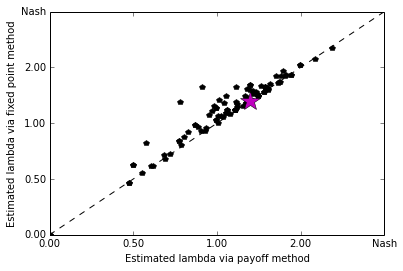

In [27]:
method_scatterplot(simdata, 1.5)

In the case of a 2x2 game, we can do something else to visualise what is going on.  Because the space of mixed strategy profiles is just equivalent to a square, we can project the QRE correspondence down onto a square.  This next function sets that up.

In [28]:
def correspondence_plot(game, df=None):
    corresp = gambit.nash.logit_principal_branch(game)
    plt.plot([ x.profile[game.players[0]][0] for x in corresp ],
             [ x.profile[game.players[1]][0] for x in corresp ], 'k--')
    plt.xlabel("Pr(Player 0 strategy 0)")
    plt.ylabel("Pr(Player 1 strategy 0)")
    
    for lam in numpy.arange(1.0, 10.1, 1.0):
        qrelam = gambit.nash.logit_atlambda(game, lam).profile
        plt.plot([ qrelam[game.players[0]][0] ],
                 [ qrelam[game.players[1]][0] ], 'kd')
        
    if df is None: return

    for (index, sample) in df.iterrows():
        lam = sample['payoff']
        fitted = gambit.nash.logit_atlambda(game, lam).profile
        plt.plot([ sample['p0s0']/(sample['p0s0']+sample['p0s1']),
                   fitted[game.players[0]][0] ],
                 [ sample['p1s0']/(sample['p1s0']+sample['p1s1']),
                   fitted[game.players[1]][0] ], 'r')
    
        lam = sample['fixedpoint']
        fitted = gambit.nash.logit_atlambda(game, lam).profile
        plt.plot([ sample['p0s0']/(sample['p0s0']+sample['p0s1']),
                   fitted[game.players[0]][0] ],
                 [ sample['p1s0']/(sample['p1s0']+sample['p1s1']),
                   fitted[game.players[1]][0] ], 'b')

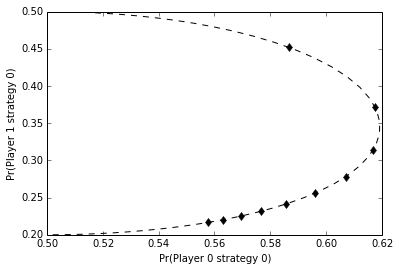

In [29]:
correspondence_plot(g)

Now, we can add to this correspondence plot information about our simulated data and fits.  For each simulated observation, we plot the simulated strategy frequencies.  We then plot from that point a red line, which links the observed frequencies to the fitted point on the QRE correspondence using the payoff method, and a blue line, which links the observed frequencies to the fitted point using the fixed-point method.  It becomes clear that the fixed-point method (blue) lines generally link up to points farther along the correspondence, i.e. ones with higher $\lambda$.

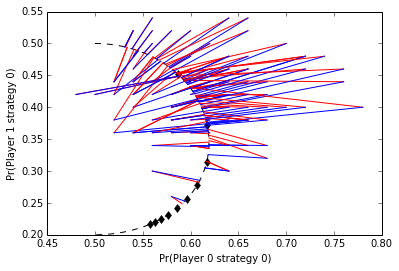

In [30]:
correspondence_plot(g, simdata)

## Other games from McKPal95

It is reasonable to ask whether this biased performance is due to some special characteristic of the games studied by Ochs.  We can look to some other games from McKelvey-Palfrey (1995) to investigate this further.

The second case study is a constant-sum game with four strategies for each player reported in

O'Neill, B. (1987) Nonmetric test of the minimax theory of two-person zerosum games. *Proceedings of the National Academy of Sciences of the USA*, **84**:2106-2109.

In [31]:
matrix = numpy.array([ [ 5, -5, -5, -5 ],
                       [ -5, -5, 5, 5 ],
                       [ -5, 5, -5, 5 ],
                       [ -5, 5, 5, -5 ] ], dtype=gambit.Rational)
matrix

array([[5, -5, -5, -5],
       [-5, -5, 5, 5],
       [-5, 5, -5, 5],
       [-5, 5, 5, -5]], dtype=object)

We again follow McKPal95 and translate these payoffs into 1982 cents for comparability.

In [32]:
matrix *= gambit.Rational(913, 1000)
game = gambit.Game.from_arrays(matrix, -matrix)

We simulate our data around the $\hat\lambda\approx 1.3$ reported by McKPal95.

In [33]:
simdata = simulate_fits(g, 1.3, 50)

In [34]:
(simdata.fixedpoint>simdata.payoff).astype(int).mean()

0.79000000000000004

In [35]:
simdata.fixedpoint.describe()

count    100.000000
mean       1.330206
std        0.863340
min        0.000000
25%        0.720926
50%        1.256126
75%        1.844871
max        3.610687
Name: fixedpoint, dtype: float64

In [36]:
simdata.payoff.describe()

count    100.000000
mean       1.137151
std        0.768048
min        0.000000
25%        0.602237
50%        1.080477
75%        1.599950
max        3.032108
Name: payoff, dtype: float64

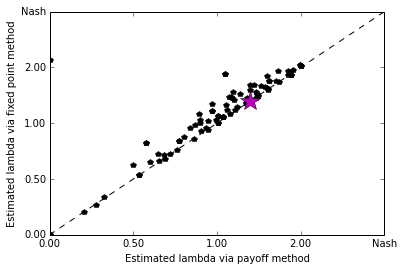

In [37]:
method_scatterplot(simdata, 1.5)

Another game considered by McKPal95 is a 5x5 constant-sum game from

Rapoport, A. and Boebel, R. (1992) Mixed strategies in strictly competitive games: A further test of the minimax hypothesis.  *Games and Economic Behavior* **4**: 261-283.

We put the estimation approaches through their paces, around the $\hat\lambda \approx 0.25$ reported by McKPal95.

In [38]:
matrix = numpy.array([ [ 10, -6, -6, -6, -6 ],
                       [ -6, -6, 10, 10, 10 ],
                       [ -6, 10, -6, -6, 10 ],
                       [ -6, 10, -6, 10, -6 ],
                       [ -6, 10, 10, -6, -6 ] ], dtype=gambit.Rational)
matrix *= gambit.Rational(713, 1000)
game = gambit.Game.from_arrays(matrix, -matrix)
simdata = simulate_fits(g, 0.25, 50)

In [39]:
simdata.fixedpoint.describe()

count    100.000000
mean       0.467369
std        0.568382
min        0.000000
25%        0.000000
50%        0.301702
75%        0.757745
max        2.084625
Name: fixedpoint, dtype: float64

In [40]:
simdata.payoff.describe()

count    100.000000
mean       0.399141
std        0.493687
min        0.000000
25%        0.000000
50%        0.264003
75%        0.643454
max        1.925047
Name: payoff, dtype: float64

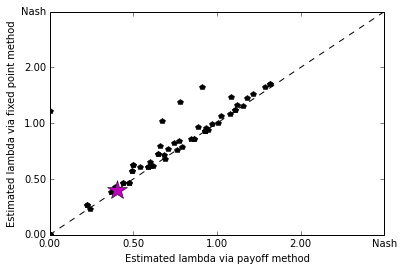

In [41]:
method_scatterplot(simdata, 0.25)

## Estimating other parameters

While it appears, from these (still preliminary) results, that the payoff method for estimating $\lambda$ is biased towards estimates which are more "noisy" than the true behaviour, this may not in practice be much of a concern.

In the view of this researcher, the real strength of the logit model is in using it to estimate other parameters of interest.  The logit model has some attractive foundations in terms of information theory which make it ideal for this task (in addition to being computationally quite tractable).

It is precisely in these applications where the payoff-based estimation approach is most attractive.  The fixed-point method becomes progressively more computationally infeasible as the game gets larger, or as the number of parameters to be considered grows.  The payoff approach on the other hand scales much more attractively.  What we really want to know, then, is not so much whether $\hat\lambda$ is biased, but whether estimates of *other* parameters of interest are systematically biased as well.

We pick this up by looking at some examples from

Goeree, Holt, and Palfrey (2002), Risk averse behavior in generalized matching pennies games.

In [42]:
matrix1 = numpy.array([ [ 200, 160 ], [ 370, 10 ]], dtype=gambit.Decimal)
matrix2 = numpy.array([ [ 160, 10 ], [ 200, 370 ]], dtype=gambit.Decimal)
game = gambit.Game.from_arrays(matrix1, matrix2)

The idea in GHP2002 is to estimate simultaneously a QRE with a common constant-relative risk aversion parameter $r$.  This utility function transforms the basic payoff matrix into (scaled) utilities given CRRA paramater $r$.

In [43]:
def transform_matrix(m, r):
    r = gambit.Decimal(str(r))
    return (numpy.power(m, 1-r) - numpy.power(10, 1-r)) / \
           (numpy.power(370, 1-r) - numpy.power(10, 1-r))

The next few functions set up the optimisation.  For the purposes of the talk, we simply look over a discrete grid of possible risk aversion parameters (to keep the running time short and reliable for a live demo!)

In [44]:
def estimate_risk_fixedpoint_method(matrix1, matrix2, freqs):
    def log_like(r):
        tm1 = transform_matrix(matrix1, r)
        tm2 = transform_matrix(matrix2, r)
        g = gambit.Game.from_arrays(tm1, tm2)
        profile = g.mixed_strategy_profile()
        for i in xrange(len(profile)):
            profile[i] = freqs[i]
        qre = gambit.nash.logit_estimate(profile)
        logL = numpy.dot(numpy.array(list(freqs)), numpy.log(list(qre.profile)))
        return logL
    results = [ (x0, log_like(x0))
                for x0 in numpy.linspace(0.01, 0.99, 100) ]
    results.sort(key=lambda r: -r[1])
    return results[0][0]

In [45]:
def estimate_payoff_method(freqs):
    def log_like(freqs, values, lam):
        logit_probs = [ [ math.exp(lam*v) for v in player ] for player in values ]
        sums = [ sum(v) for v in logit_probs ]
        logit_probs = [ [ v/s for v in vv ]
                          for (vv, s) in zip(logit_probs, sums) ]
        logit_probs = [ v for player in logit_probs for v in player ]
        logit_probs = [ max(v, 1.0e-293) for v in logit_probs ]
        return sum([ f*math.log(p) for (f, p) in zip(list(freqs), logit_probs) ])
    p = freqs.copy()
    p.normalize()
    v = p.strategy_values()
    res = scipy.optimize.minimize(lambda x: -log_like(freqs, v, x[0]), (0.1,),
                                  bounds=((0.0, 10.0),))
    return log_like(freqs, v, res.x[0])

def estimate_risk_payoff_method(matrix1, matrix2, freqs):
    def log_like(r):
        tm1 = transform_matrix(matrix1, r)
        tm2 = transform_matrix(matrix2, r)
        g = gambit.Game.from_arrays(tm1, tm2)
        profile = g.mixed_strategy_profile()
        for i in xrange(len(profile)):
            profile[i] = freqs[i]
        logL = estimate_payoff_method(profile)
        return logL
    results = [ (x0, log_like(x0))
                for x0 in numpy.linspace(0.01, 0.99, 100) ]
    results.sort(key=lambda r: -r[1])
    return results[0][0]

This is a variation on the simulator driver, where we will focus on collecting statistics on the risk aversion parameters estimated.

In [46]:
def simulate_fits(game, matrix1, matrix2, r, lam, N, trials=100):
    qre = gambit.nash.logit_atlambda(game, lam).profile
    samples = [ ]
    for sample in xrange(trials):
        f = game.mixed_strategy_profile()
        for player in game.players:
            f[player] = numpy.random.multinomial(N, qre[player], size=1)[0]
        samples.append(f)
    labels = [ "p%ds%d" % (i, j)
               for (i, player) in enumerate(game.players)
               for (j, strategy) in enumerate(player.strategies) ]
    return pandas.DataFrame([ list(freqs) +
                              [ estimate_risk_fixedpoint_method(matrix1, matrix2, freqs),
                                estimate_risk_payoff_method(matrix1, matrix2, freqs),
                                r ]
                              for freqs in samples ],
                            columns=labels + [ 'r_fixedpoint', 'r_payoff', 'actual' ])

GHP02 report a risk aversion parameter estimate of $r=0.44$ for this game, so we adopt this as the true value.  Likewise, they report a logit parameter estimate of $\frac{1}{\lambda}=0.150$ which we use as the parameter for the data generating process in the simulation.

In [47]:
game = gambit.Game.from_arrays(transform_matrix(matrix1, gambit.Decimal("0.44")),
                               transform_matrix(matrix2, gambit.Decimal("0.44")))

In [48]:
simdata = simulate_fits(game, matrix1, matrix2, 0.44, 1.0/0.150, 100, trials=30)
simdata

,p0s0,p0s1,p1s0,p1s1,r_fixedpoint,r_payoff,actual
0,40,60,67,33,0.485152,0.504949,0.44
1,49,51,70,30,0.613838,0.613838,0.44
2,35,65,69,31,0.564343,0.574242,0.44
3,56,44,68,32,0.910808,0.910808,0.44
4,48,52,62,38,0.376263,0.376263,0.44
5,51,49,64,36,0.504949,0.504949,0.44
6,47,53,67,33,0.495051,0.495051,0.44
7,56,44,68,32,0.910808,0.910808,0.44
8,52,48,70,30,0.702929,0.702929,0.44
9,33,67,69,31,0.584141,0.594040,0.44


In [49]:
simdata.r_fixedpoint.describe()

count    30.000000
mean      0.550485
std       0.151260
min       0.346566
25%       0.462879
50%       0.519798
75%       0.606414
max       0.910808
Name: r_fixedpoint, dtype: float64

In [50]:
simdata.r_payoff.describe()

count    30.000000
mean      0.554444
std       0.149471
min       0.356465
25%       0.470303
50%       0.524747
75%       0.608889
max       0.910808
Name: r_payoff, dtype: float64

## (Tentative) conclusions

* The payoff-based approach to estimating QRE is attractive and offers hope of fitting much richer models.
* Preliminary indications are that estimated QRE parameters $\hat\lambda$ obtained by using the payoff method are biased (in the direction of understating precision), so these should be used with care in small samples.
* At least in the generalized matching pennies game, the bias in $\hat\lambda$ does not seem to result in any bias in risk attitude estimates.